In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import itertools
from keras.optimizers import RMSprop, Adadelta, Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential

In [2]:
%matplotlib inline
dig = load_digits()

<Figure size 432x288 with 0 Axes>

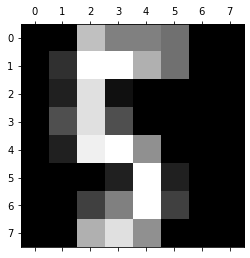

In [3]:

plt.gray()
plt.matshow(dig.images[25])

In [4]:
for k in dig.keys()-['DESCR']:
    print(k, ':', dig[k].shape)

target_names : (10,)
images : (1797, 8, 8)
target : (1797,)
data : (1797, 64)


In [5]:
binary_target = pd.get_dummies(dig.target)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(dig.data, binary_target, test_size=0.1, random_state=20)

In [9]:
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(84,activation='relu'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 84)                10836     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               10880     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 31,326
Trainable params: 31,326
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
26/26 [==============================] - 1s 2ms/step - loss: 2.5511 - categorical_accuracy: 0.0994
Epoch 2/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5314 - categorical_accuracy: 0.0983
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5947 - categorical_accuracy: 0.0956
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5595 - categorical_accuracy: 0.0929
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 2.5413 - categorical_accuracy: 0.1002
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5326 - categorical_accuracy: 0.1021
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5653 - categorical_accuracy: 0.0963
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5425 - categorical_accuracy: 0.1032
Epoch 9/50
26/26 [==============================] - 0s 2ms/step - loss: 2.5134 - categorical_accuracy: 0.0956
Epoch 10/5

In [13]:
scores = model.evaluate(x_val, y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

6/6 [==============================] - 0s 2ms/step - loss: 2.4744 - categorical_accuracy: 0.0944

categorical_accuracy: 9.44%


In [14]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

class MyNN:
    def __init__(self, x, y):
        self.x = x
        neurons = 128
        self.lr = 0.5
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = sigmoid(z3)
        
    def backprop(self):
        loss = error(self.a3, self.y)
        print('Error :', loss)
        a3_delta = cross_entropy(self.a3, self.y) # w3
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1

        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.x.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a3.argmax()

In [15]:

model = MyNN(x_train/16.0, np.array(y_train))

In [16]:
epochs = 2000
for x in range(epochs):
    model.feedforward()
    model.backprop()

Error : 4.986836954371644
Error : 7.867963634096736
Error : 6.644585017355182
Error : 5.234390096095464
Error : 4.295671411043557
Error : 3.120889505780669
Error : 3.067197640629956
Error : 1.8590101235082042
Error : 2.0792889975610787
Error : 1.5966387761382939
Error : 1.8731127650825052
Error : 1.431966250759389
Error : 1.7962812898389429
Error : 1.7567727649931613
Error : 1.8800667624290115
Error : 1.2091202157956134
Error : 1.2493018632911408
Error : 1.093953159816809
Error : 1.4899864324537695
Error : 1.4118958166792903
Error : 1.6444694353636349
Error : 1.008909723094882
Error : 1.505021523858712
Error : 1.0863486769435728
Error : 1.6345864911461783
Error : 0.9850270104607434
Error : 1.1549009467152467
Error : 0.7278050157893756
Error : 1.3482617044796537
Error : 0.780650527715677
Error : 1.0000910404466155
Error : 0.6092116111939161
Error : 1.1929823267577857
Error : 0.6359847316109954
Error : 0.9004720490575184
Error : 0.5394060316386192
Error : 1.0431618932382847
Error : 0.553

In [19]:
def get_acc(x, y):
    acc = 0
    for xx,yy in zip(x, y):
        s = model.predict(xx)
        if s == np.argmax(yy):
            acc +=1
    return acc/len(x)*100

In [20]:
print("Training accuracy : ", get_acc(x_train/16, np.array(y_train)))
print("Test accuracy : ", get_acc(x_val/16, np.array(y_val)))

Training accuracy :  100.0
Test accuracy :  98.88888888888889
